In [1]:
#!pip install pandas==2.0.3
!pip install feature_engine sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 344.3/344.3 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.2/12.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.9/169.9 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.2/82.2 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 39.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nv

# Importing libraries

In [65]:
import pandas as pd
import numpy as np
import math

import seaborn as sns
import matplotlib.pyplot as plt

import lightgbm as lgb
from feature_engine import encoding as ce

from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, roc_curve, auc, confusion_matrix, precision_score, accuracy_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.datasets import load_breast_cancer

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


import torch

from sdv.single_table import CTGANSynthesizer
from sdv.datasets.demo import get_available_demos
from sdv.datasets.demo import download_demo
from sdv.evaluation.single_table import run_diagnostic

%matplotlib inline

import warnings
warnings.simplefilter('ignore')

# Data loading

In [3]:
data = pd.read_csv('drive/MyDrive/Diploma/data/BankChurners.csv')

churn_map = {'Existing Customer': 0,
            'Attrited Customer': 1}
data['target'] = data['Attrition_Flag'].map(churn_map)

data.drop('Attrition_Flag', axis=1, inplace=True)

In [4]:
data.drop(['CLIENTNUM',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
     'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'],
        axis=1, inplace=True)

In [5]:
data.head()

Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
0            45      M                3     High School        Married   
1            49      F                5        Graduate         Single   
2            51      M                3        Graduate        Married   
3            40      F                4     High School        Unknown   
4            40      M                3      Uneducated        Married   

  Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
0     $60K - $80K          Blue              39                         5   
1  Less than $40K          Blue              44                         6   
2    $80K - $120K          Blue              36                         4   
3  Less than $40K          Blue              34                         3   
4     $60K - $80K          Blue              21                         5   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       1                      3       12691.0   
1                       1                      2        8256.0   
2                       1                      0        3418.0   
3                       4                      1        3313.0   
4                       1                      0        4716.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                  777          11914.0                 1.335   
1                  864           7392.0                 1.541   
2                    0           3418.0                 2.594   
3                 2517            796.0                 1.405   
4                    0           4716.0                 2.175   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0             1144              42                1.625   
1             1291              33                3.714   
2             1887              20                2.333   
3             1171              20                2.333   
4              816              28                2.500   

   Avg_Utilization_Ratio  target  
0                  0.061       0  
1                  0.105       0  
2                  0.000       0  
3                  0.760       0  
4                  0.000       0

In [6]:
data.dtypes

Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
target                        int64
dtype: object

In [7]:
data.shape

(10127, 20)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['target'], axis=1),
                                                    data['target'], test_size=0.1,
                                                    shuffle=True, stratify=data['target'],
                                                    random_state=42)

In [9]:
y_train.mean(), y_test.mean()

(0.16063199473337722, 0.16090819348469892)

In [10]:
X_train.shape, X_test.shape,

((9114, 19), (1013, 19))

In [11]:
real_data = X_train.copy()
real_data['target'] = y_train
categorical_features = list(real_data.loc[:, real_data.dtypes == object].columns)

print(categorical_features)

['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']


# Generating synthetic data

In [12]:
from sdv.metadata import SingleTableMetadata

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)
python_dict = metadata.to_dict()

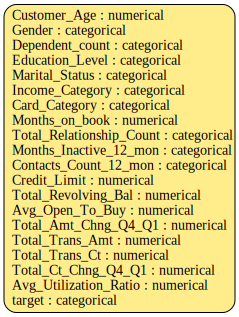

In [13]:
metadata.visualize() # use update_column to modify the information about a column in your metadata.

In [14]:
metadata.validate()

In [15]:
metadata.validate_data(data=real_data)

In [16]:
real_data.Months_Inactive_12_mon.value_counts()

Months_Inactive_12_mon
3    3450
2    2948
1    2026
4     397
5     159
6     110
0      24
Name: count, dtype: int64

In [17]:
# %%time
# from ctgan import CTGAN
# from tqdm import tqdm

# np.random.seed(0)
# torch.manual_seed(0)

# ctgan_model = CTGAN()
# ctgan_model.fit(real_data, categorical_features)
# synthetic_data = ctgan_model.sample(n=real_data.shape[0])

In [18]:
%%time
ctgan_model = CTGANSynthesizer(
    metadata, # required
    enforce_rounding=True,
    epochs=300,
    verbose=True,
    enforce_min_max_values=True
)
ctgan_model.fit(real_data)

synthetic_data = ctgan_model.sample(num_rows=real_data.shape[0])
synthetic_data.head()

Gen. (-0.70) | Discrim. (-0.10): 100%|██████████| 300/300 [16:23<00:00,  3.28s/it]


CPU times: user 14min 6s, sys: 14.4 s, total: 14min 20s
Wall time: 17min 16s


Customer_Age Gender  Dependent_count Education_Level Marital_Status  \
0            54      F                3     High School        Married   
1            47      F                1         College        Unknown   
2            49      F                2         Unknown         Single   
3            52      F                2   Post-Graduate         Single   
4            32      M                2        Graduate         Single   

  Income_Category Card_Category  Months_on_book  Total_Relationship_Count  \
0     $40K - $60K          Blue              39                         1   
1  Less than $40K          Blue              39                         5   
2    $80K - $120K          Blue              36                         3   
3  Less than $40K          Blue              43                         3   
4         $120K +          Blue              34                         5   

   Months_Inactive_12_mon  Contacts_Count_12_mon  Credit_Limit  \
0                       2                      3        8935.7   
1                       2                      3        4721.2   
2                       2                      4        8665.4   
3                       2                      3        1852.0   
4                       3                      2       34516.0   

   Total_Revolving_Bal  Avg_Open_To_Buy  Total_Amt_Chng_Q4_Q1  \
0                    0          19290.3                 0.580   
1                 1260           5800.0                 0.628   
2                 1492           9783.7                 0.676   
3                 1873            489.6                 0.759   
4                 2032          21569.4                 0.463   

   Total_Trans_Amt  Total_Trans_Ct  Total_Ct_Chng_Q4_Q1  \
0             8990              71                0.567   
1             4610              66                0.576   
2             4302              70                0.598   
3             1588              84                0.535   
4             1751             111                0.685   

   Avg_Utilization_Ratio  target  
0                  0.001       0  
1                  0.371       0  
2                  0.243       0  
3                  0.668       1  
4                  0.088       1

In [19]:
ctgan_model.get_parameters()

{'enforce_min_max_values': True,
 'enforce_rounding': True,
 'locales': ['en_US'],
 'embedding_dim': 128,
 'generator_dim': (256, 256),
 'discriminator_dim': (256, 256),
 'generator_lr': 0.0002,
 'generator_decay': 1e-06,
 'discriminator_lr': 0.0002,
 'discriminator_decay': 1e-06,
 'batch_size': 500,
 'discriminator_steps': 1,
 'log_frequency': True,
 'verbose': True,
 'epochs': 300,
 'pac': 10,
 'cuda': True}

In [20]:
ctgan_model.get_loss_values()

Epoch  Generator Loss  Discriminator Loss
0        0        1.267615           -0.378147
1        1        0.654749           -0.011451
2        2        0.780550           -0.004225
3        3        0.792578            0.025277
4        4        0.746008            0.064836
..     ...             ...                 ...
295    295       -1.138691           -0.240276
296    296       -1.344395           -0.122331
297    297       -0.954084           -0.088946
298    298       -1.295088           -0.053952
299    299       -0.698296           -0.103657

[300 rows x 3 columns]

 ### Evaluating real vs. synthetic data

In [21]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 20/20 [00:00<00:00, 434.93it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 128.18it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [22]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 20/20 [00:00<00:00, 176.77it/s]|
Column Shapes Score: 87.72%

(2/2) Evaluating Column Pair Trends: |██████████| 190/190 [00:10<00:00, 18.67it/s]|
Column Pair Trends Score: 40.99%

Overall Score (Average): 64.36%



In [23]:
quality_report.get_details('Column Shapes')

Column        Metric     Score
0               Customer_Age  KSComplement  0.892583
1                     Gender  TVComplement  0.886548
2            Dependent_count  TVComplement  0.849353
3            Education_Level  TVComplement  0.846061
4             Marital_Status  TVComplement  0.876344
5            Income_Category  TVComplement  0.889401
6              Card_Category  TVComplement  0.961817
7             Months_on_book  KSComplement  0.809963
8   Total_Relationship_Count  TVComplement  0.863178
9     Months_Inactive_12_mon  TVComplement  0.818192
10     Contacts_Count_12_mon  TVComplement  0.757077
11              Credit_Limit  KSComplement  0.963024
12       Total_Revolving_Bal  KSComplement  0.923744
13           Avg_Open_To_Buy  KSComplement  0.895765
14      Total_Amt_Chng_Q4_Q1  KSComplement  0.873820
15           Total_Trans_Amt  KSComplement  0.874150
16            Total_Trans_Ct  KSComplement  0.940092
17       Total_Ct_Chng_Q4_Q1  KSComplement  0.883805
18     Avg_Utilization_Ratio  KSComplement  0.841892
19                    target  TVComplement  0.897191

In [24]:
from sdv.evaluation.single_table import get_column_plot

feat_for_comp = real_data.columns.to_list()

for column_name in feat_for_comp:
  fig = get_column_plot(
  metadata=metadata,
  real_data=real_data,
  synthetic_data=synthetic_data,
  column_name=column_name,
  #plot_type='bar'
  )
  fig.show()

# Classification. Bank churners dataset

In [25]:
LR_pipe = Pipeline([
    ('encoding', ce.OrdinalEncoder(
       encoding_method='arbitrary', variables=categorical_features)),
    ('scaler', StandardScaler()),
    ('RF', LogisticRegression())
    ])

RF_pipe = Pipeline([
    ('encoding', ce.OrdinalEncoder(
       encoding_method='arbitrary', variables=categorical_features)),
    ('scaler', StandardScaler()),
    ('RF', RandomForestClassifier())
    ])

In [59]:
def lgbm_predict(xx_train, yy_train, xx_test, yy_test, categorical_features, reg=False):
  for col in categorical_features:
    xx_train[col] = xx_train[col].astype('category')
    xx_test[col] = xx_test[col].astype('category')
  if not reg:
    model = lgb.LGBMClassifier(random_state=42, categorical_feature=categorical_features)
    model.fit(xx_train, yy_train)
    y_pred_test = model.predict_proba(xx_test)[:, 1]
  else:
    model = lgb.LGBMRegressor(random_state=42, categorical_feature=categorical_features)
    model.fit(xx_train, yy_train)
    y_pred_test = model.predict(xx_test)
  return y_pred_test

def fit_predict(clf, xx_train, yy_train, xx_test, yy_test, reg=False):
  clf.fit(xx_train,yy_train)
  if not reg:
    y_pred_test = clf.predict_proba(xx_test)[:, 1]
  else:
      y_pred_test = clf.predict(xx_test)
  return y_pred_test


In [27]:
y_pred_test_initial_lr = fit_predict(LR_pipe, X_train.copy(), y_train, X_test, y_test)
y_pred_test_ctgan_lr = fit_predict(LR_pipe, synthetic_data.drop(['target'], axis=1), synthetic_data['target'], X_test, y_test)

y_pred_test_initial_rf = fit_predict(RF_pipe, X_train.copy(), y_train, X_test, y_test)
y_pred_test_ctgan_rf = fit_predict(RF_pipe, synthetic_data.drop(['target'], axis=1), synthetic_data['target'], X_test, y_test)

y_pred_test_initial_lgbm = lgbm_predict(X_train.copy(), y_train, X_test, y_test, categorical_features)
y_pred_test_ctgan_lgbm = lgbm_predict(synthetic_data.drop(['target'], axis=1), synthetic_data['target'], X_test, y_test, categorical_features)

[LightGBM] [Warning] categorical_feature is set=Gender,Education_Level,Marital_Status,Income_Category,Card_Category, categorical_column=1,3,4,5,6 will be ignored. Current value: categorical_feature=Gender,Education_Level,Marital_Status,Income_Category,Card_Category
[LightGBM] [Info] Number of positive: 1464, number of negative: 7650
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2051
[LightGBM] [Info] Number of data points in the train set: 9114, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.160632 -> initscore=-1.653533
[LightGBM] [Info] Start training from score -1.653533
[LightGBM] [Warning] categorical_feature is set=Gender,Education_Level,Marital_Status,Income_Category,Card_Category, categorical_column=1,3,4,5,6 will be ignored. Current value: c

In [28]:
df_lr = pd.DataFrame(data=[roc_auc_score(y_test,  y_pred_test_initial_lr), roc_auc_score(y_test,  y_pred_test_ctgan_lr)],
                     columns = ['Test'],
                     index = ['Initial', 'CTGAN'] )
df_lr['model']='LR'

df_rf = pd.DataFrame(data=[roc_auc_score(y_test,  y_pred_test_initial_rf), roc_auc_score(y_test,  y_pred_test_ctgan_rf)],
                     columns = ['Test'],
                     index = ['Initial', 'CTGAN'] )
df_rf['model']='RF'

df_lgbm = pd.DataFrame(data=[roc_auc_score(y_test,  y_pred_test_initial_lgbm), roc_auc_score(y_test,  y_pred_test_ctgan_lgbm)],
                   columns = ['Test'],
                      index = ['Initial', 'CTGAN'] )
df_lgbm['model']='Lgbm'

In [52]:
df_lr

Test model
Initial  0.909802    LR
CTGAN    0.820534    LR

# Plot models's quality

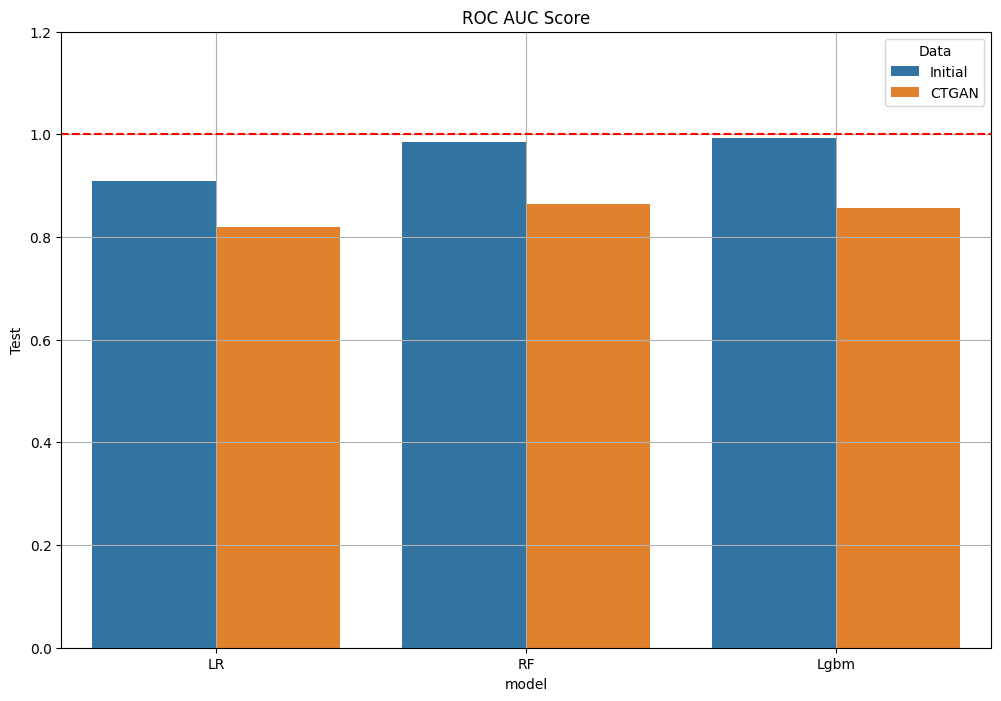

In [29]:
df=pd.concat([df_lr, df_rf, df_lgbm])
df.index.rename('Data', inplace=True)
df.reset_index(inplace=True)

fig = plt.figure(figsize=(12,8))
sns.barplot(x = 'model', y = 'Test', hue = 'Data', data = df)
plt.plot([-0.5, 2.5], [1, 1], color="red", linestyle="--")
plt.title('ROC AUC Score')
plt.xlim([-0.5,2.5])
plt.ylim([0,1.2])
plt.grid()
plt.show()

In [30]:
color_list = ["blue", "orange", "green", "red", "black", "purple"]
def plot_roc_curve(y_all):
    fig = plt.figure(figsize=(12, 8))
    lw = 2

    for i, y_label in enumerate(y_all):
        y_true, y_pred = np.array(y_all[y_label][0]), np.array(y_all[y_label][1])

        [fpr, tpr, tresholds] = roc_curve(y_true, y_pred)
        metric_value = auc(fpr, tpr)
        plt.plot(
            fpr,
            tpr,
            color=color_list[i],
            lw=lw,
            label=f"AUC {y_label} {round(metric_value, 3)}",
        )

    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.title("Roc curve", fontsize=18)
    plt.xlabel("False Positive Rate", fontsize=18)
    plt.ylabel("True Positive Rate", fontsize=18)
    plt.grid(color="gray", linestyle="--", linewidth=0.5)
    plt.legend(loc="lower right", fontsize=14)
    plt.show()

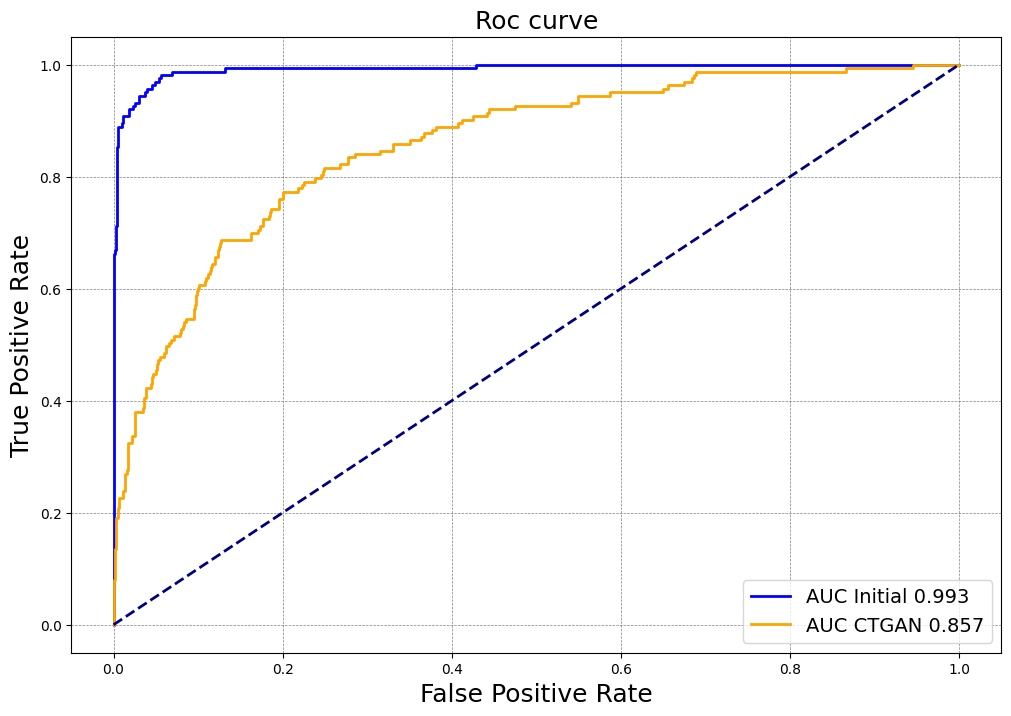

In [31]:
y_plot={'Initial': [y_test, y_pred_test_initial_lgbm],
        'CTGAN': [y_test, y_pred_test_ctgan_lgbm]}
plot_roc_curve(y_plot)

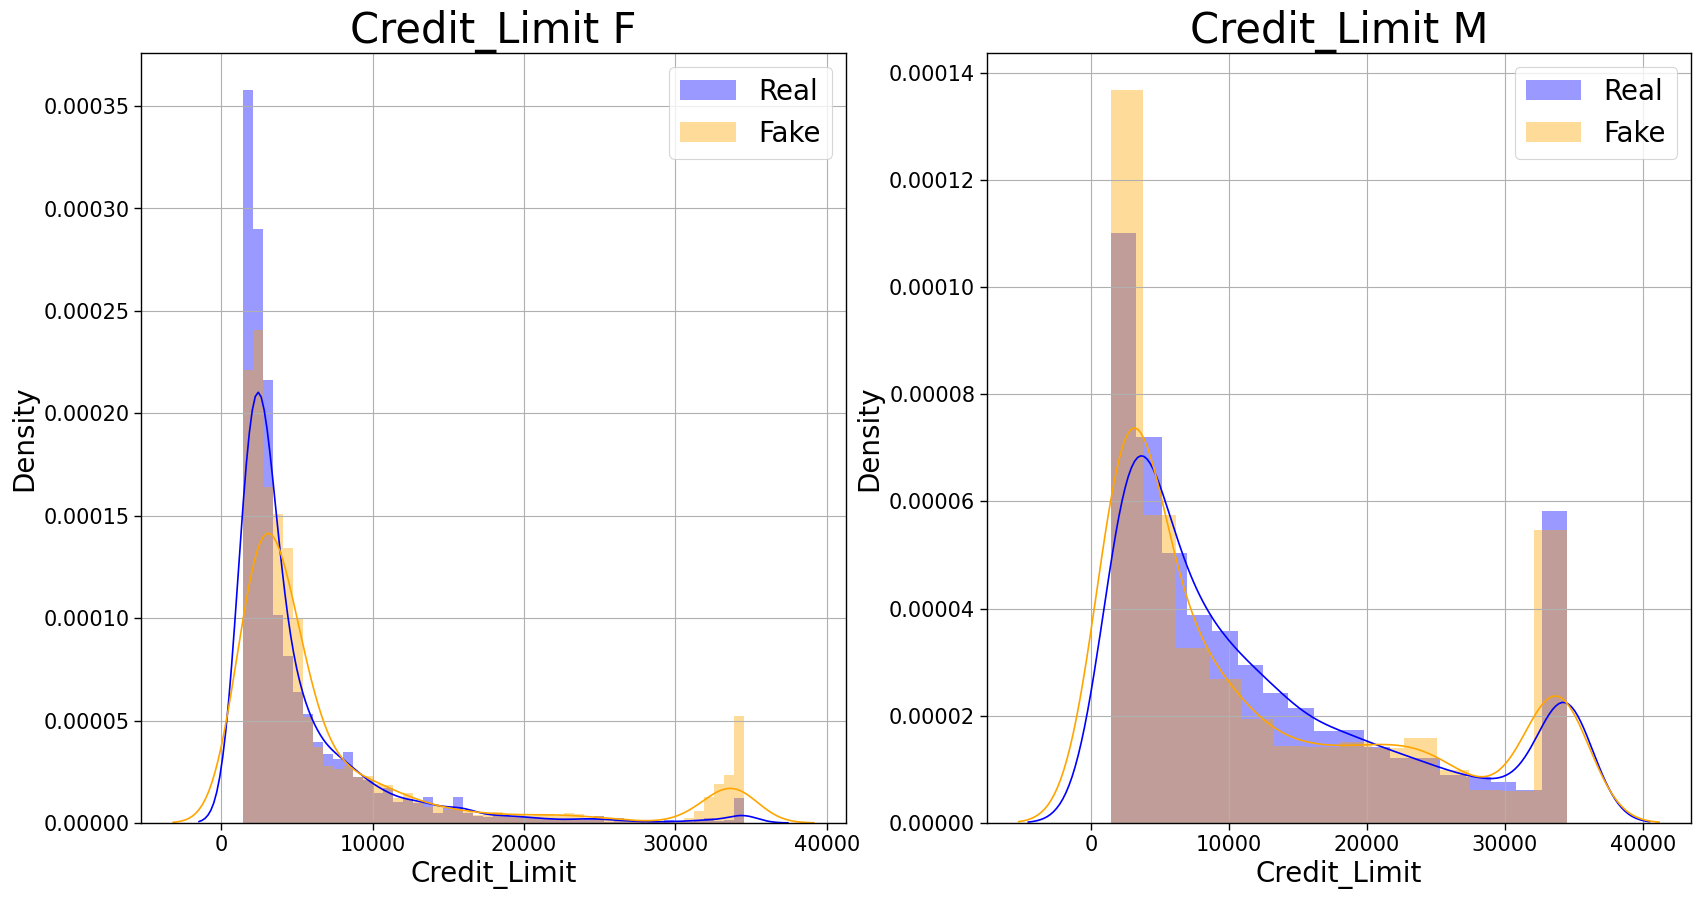

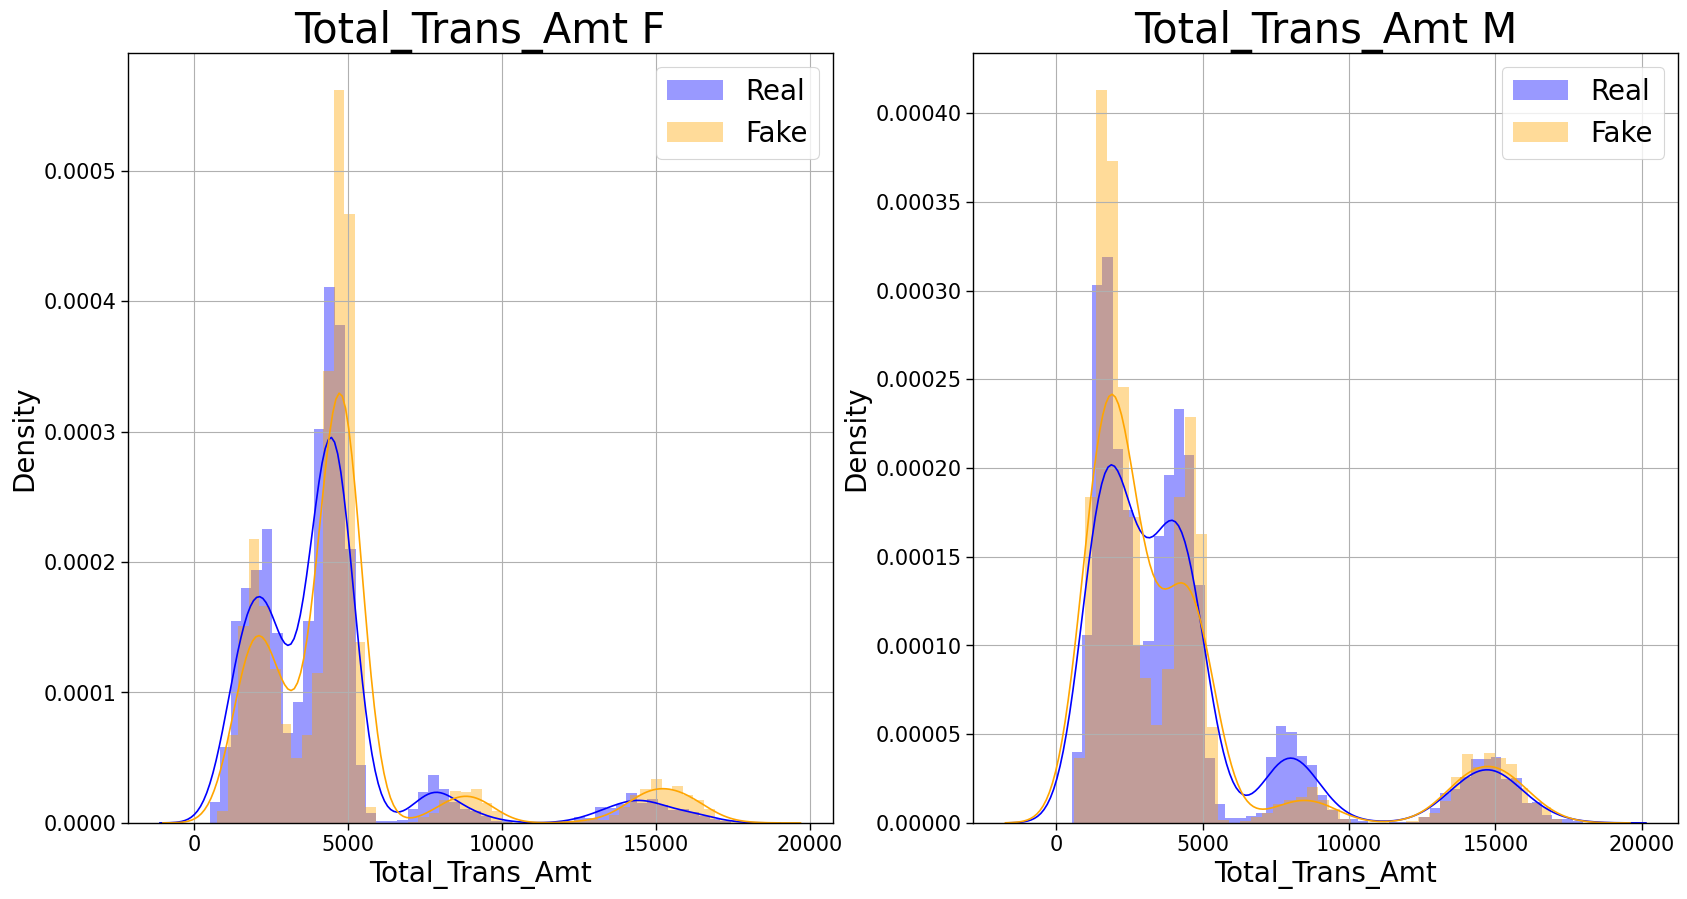

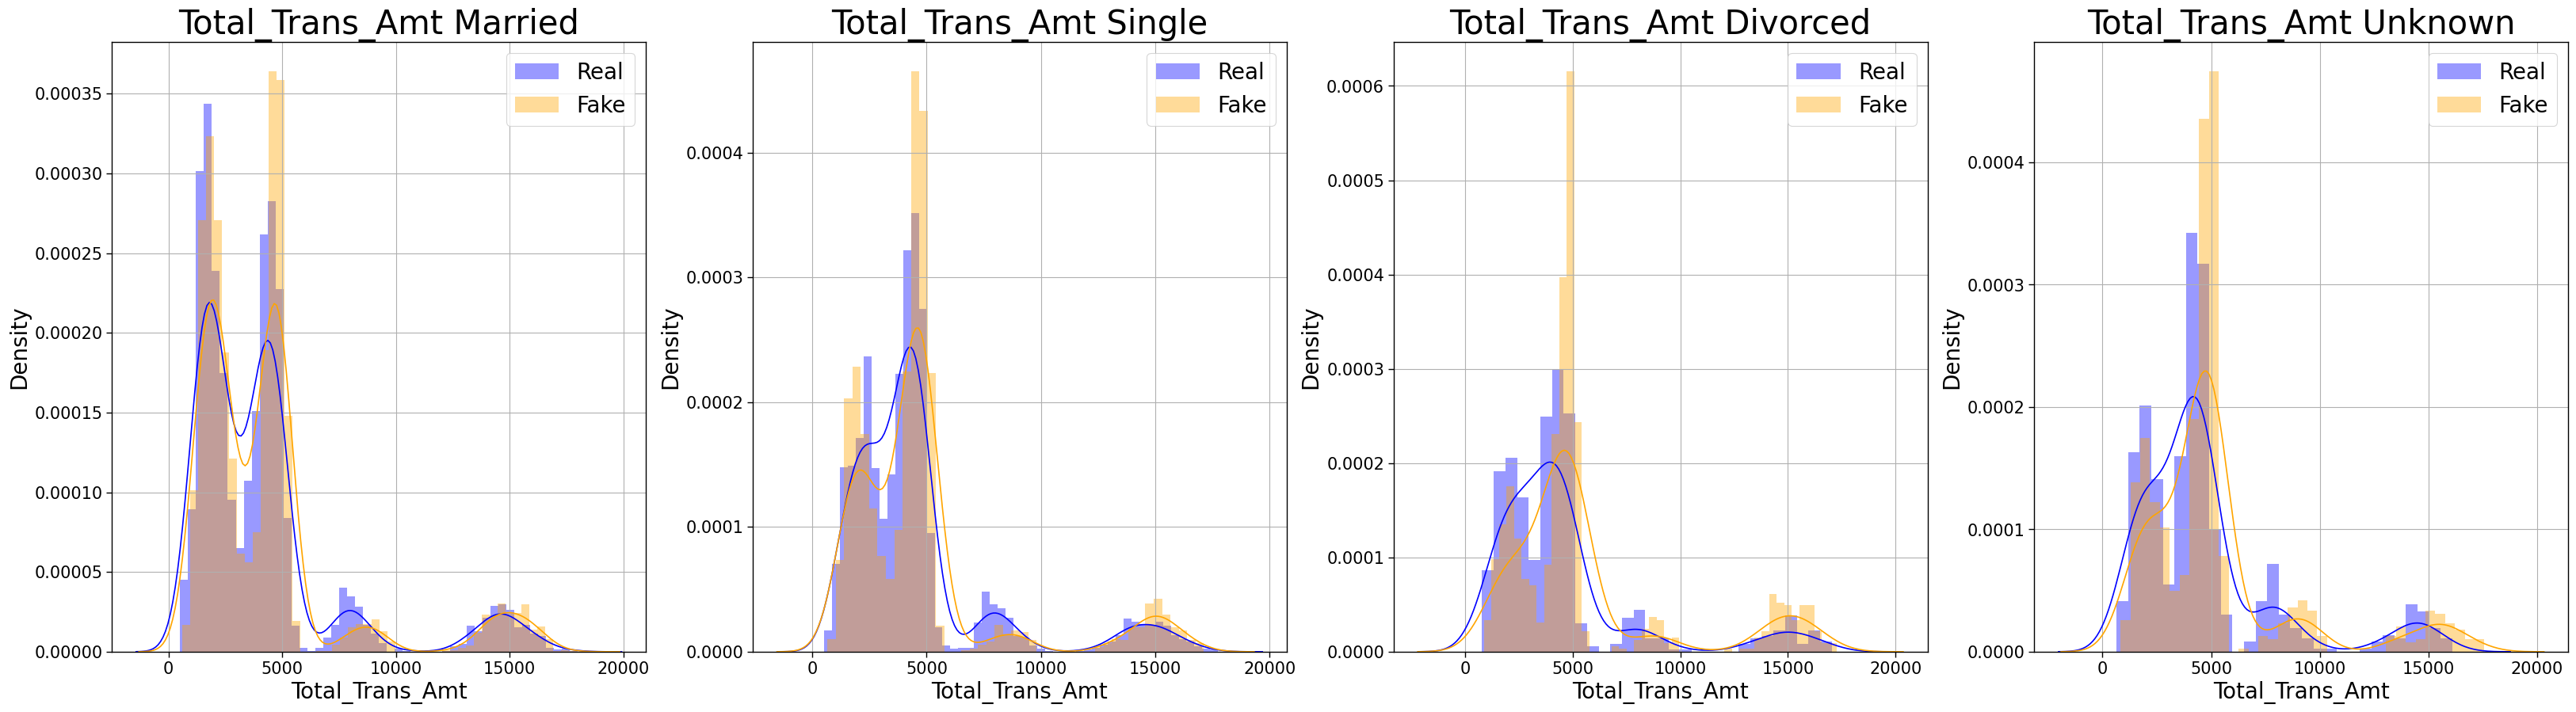

In [32]:
plot_cols = {'Gender': ['Credit_Limit', 'Total_Trans_Amt'],
            'Marital_Status': ['Total_Trans_Amt']}
sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":20, "legend.fontsize": 20, "xtick.labelsize":15, "ytick.labelsize":15})
for cat_name in plot_cols:
  cats= synthetic_data[cat_name].value_counts().index
  for col in plot_cols[cat_name]:
    fig, ax= plt.subplots(1, len(cats), figsize=(10*len(cats), 10),)
    for i, cat in enumerate(cats):
      sns.distplot(X_train[X_train[cat_name]==cat][col], ax=ax[i], label='Real', color = 'blue')
      sns.distplot(synthetic_data[synthetic_data[cat_name]==cat][col], ax=ax[i], label='Fake', color = 'orange')
      ax[i].grid(True)
      ax[i].set_title(f'{col} {cat}')
      ax[i].legend(loc=0)

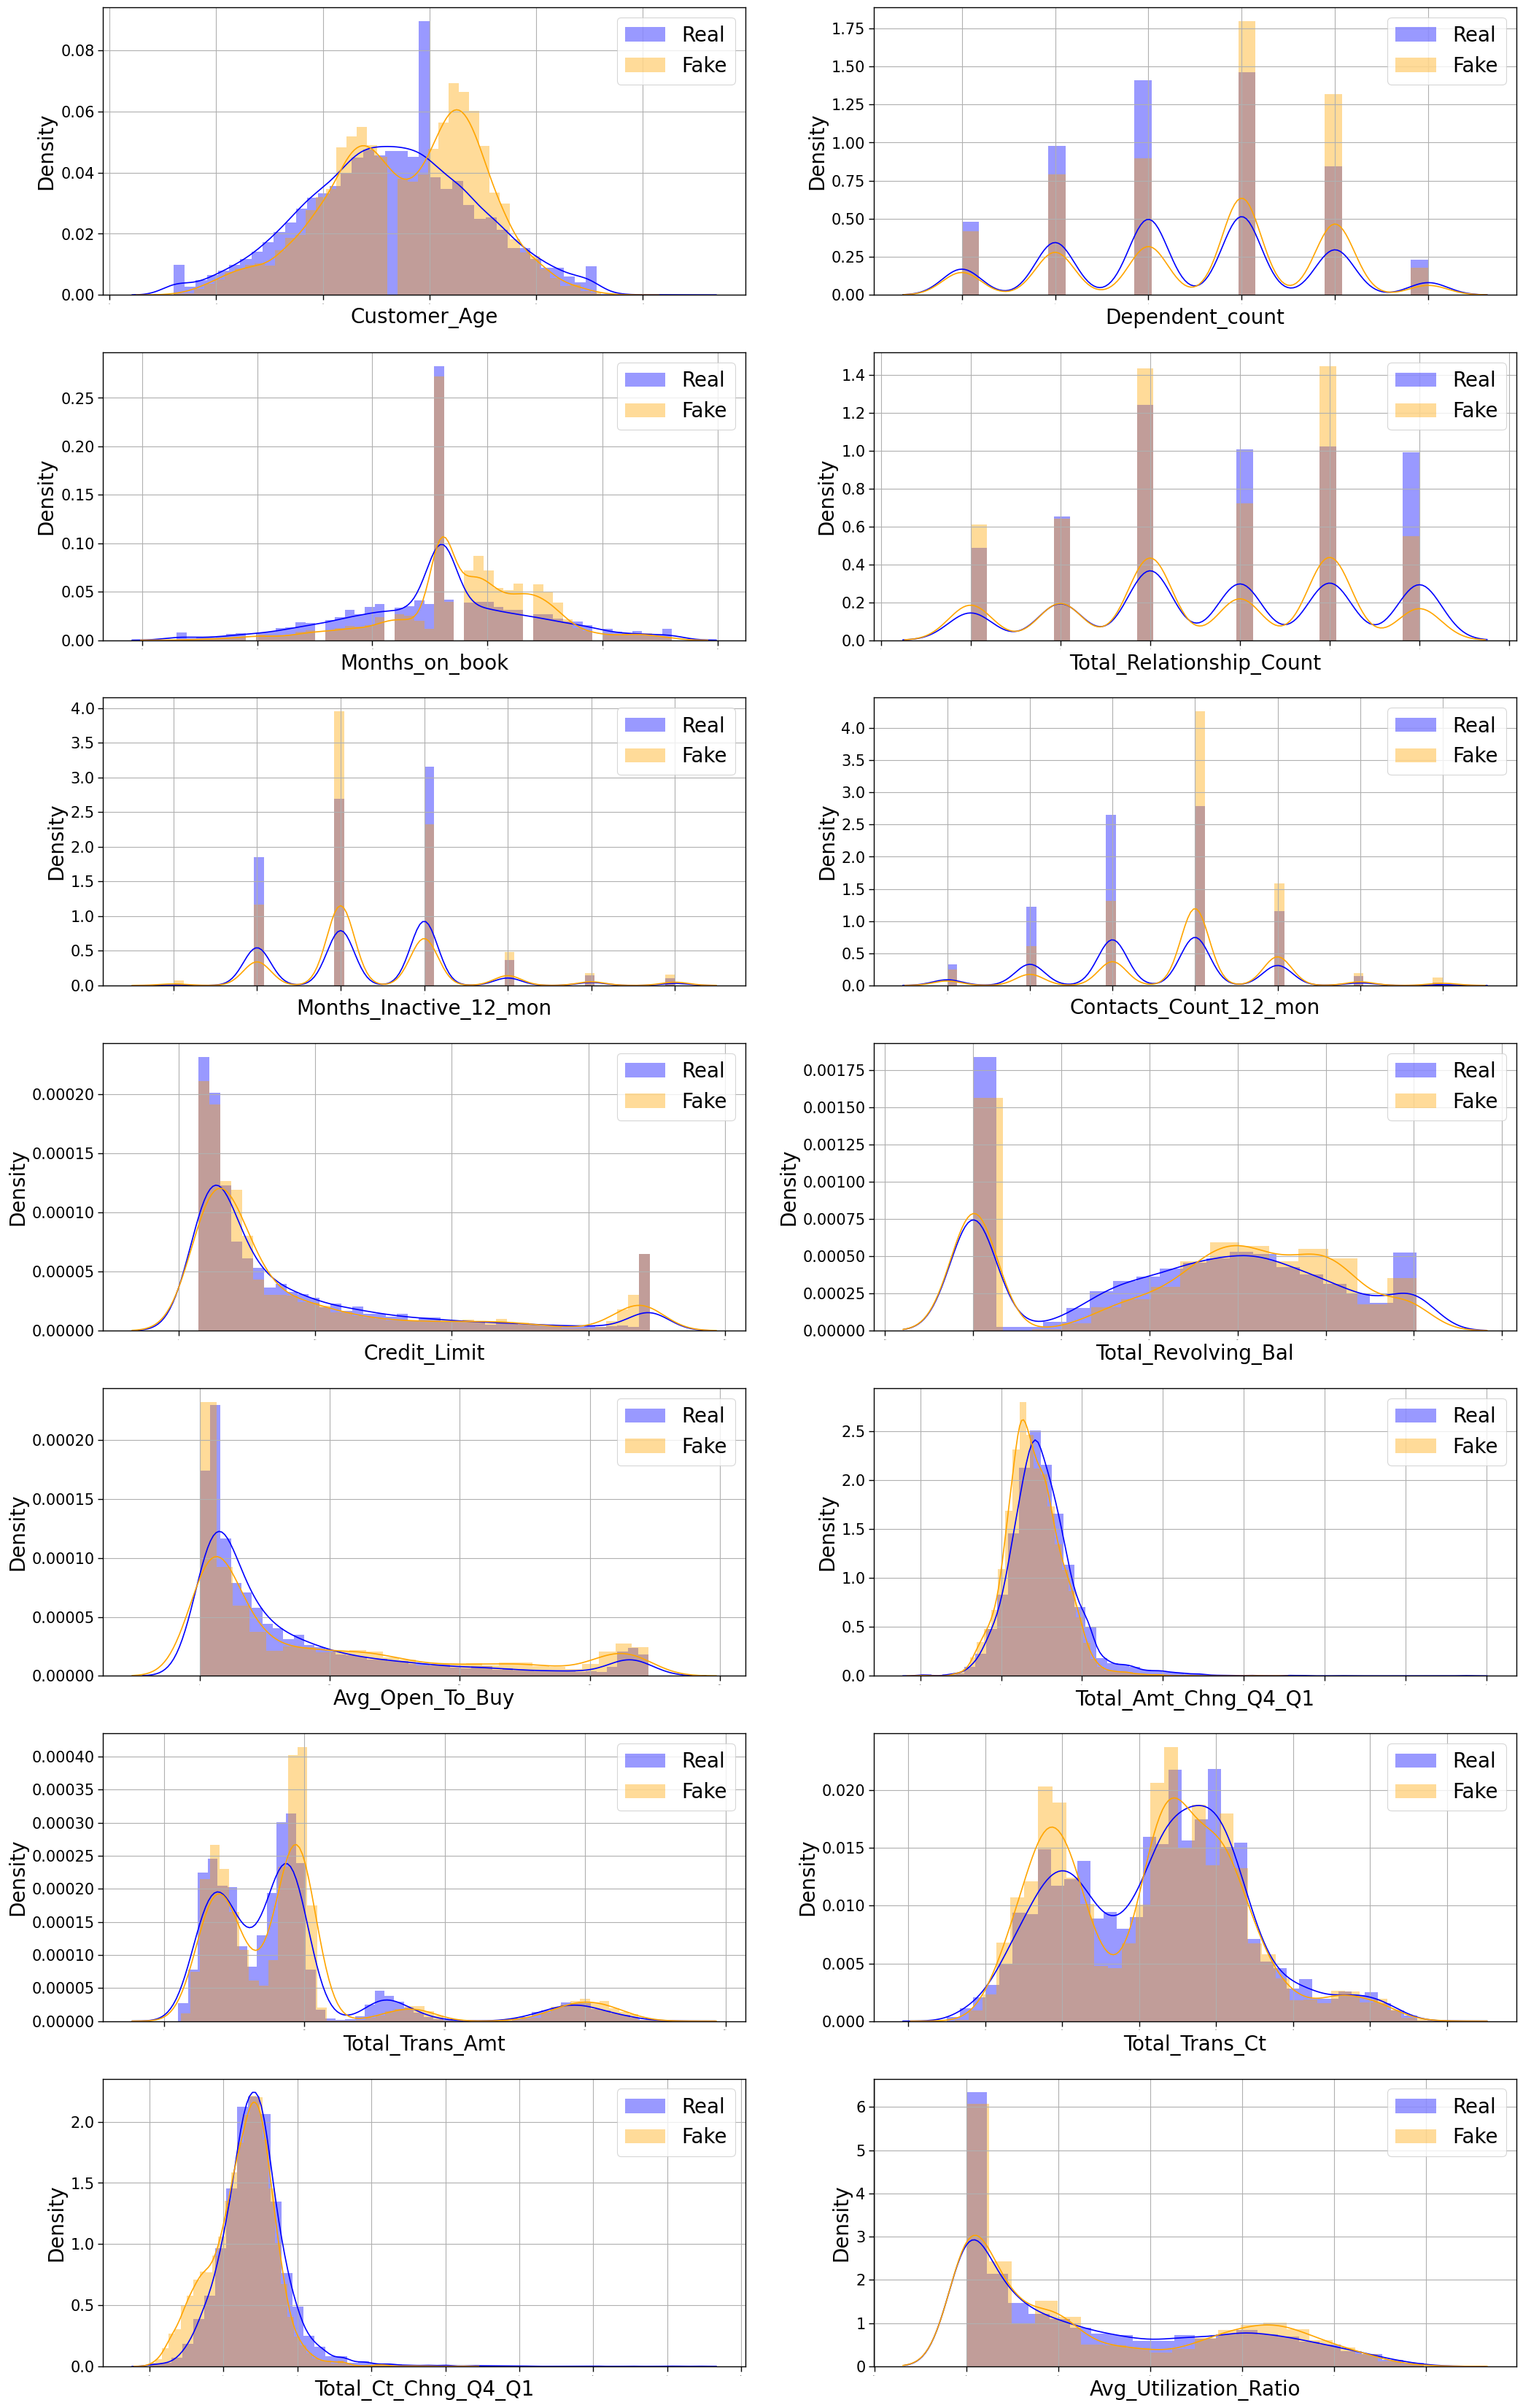

In [33]:
cont_data = [ c for c in X_train.columns if c not in categorical_features]
cols = 2

rows =max (1 , len(cont_data) // cols )

sns.set_context("paper", rc={"axes.titlesize":30,"axes.labelsize":20, "legend.fontsize": 20, "xtick.labelsize":1, "ytick.labelsize":15})

fig, ax= plt.subplots(rows, cols, figsize=(25, 6 * rows))

axes = ax.flatten()

for i, col in enumerate(cont_data):
  sns.distplot(X_train[col], ax=axes[i], label='Real', color = 'blue')
  sns.distplot(synthetic_data[col], ax=axes[i], label='Fake', color = 'orange')
  axes[i].grid(True)
  axes[i].legend(loc=0)

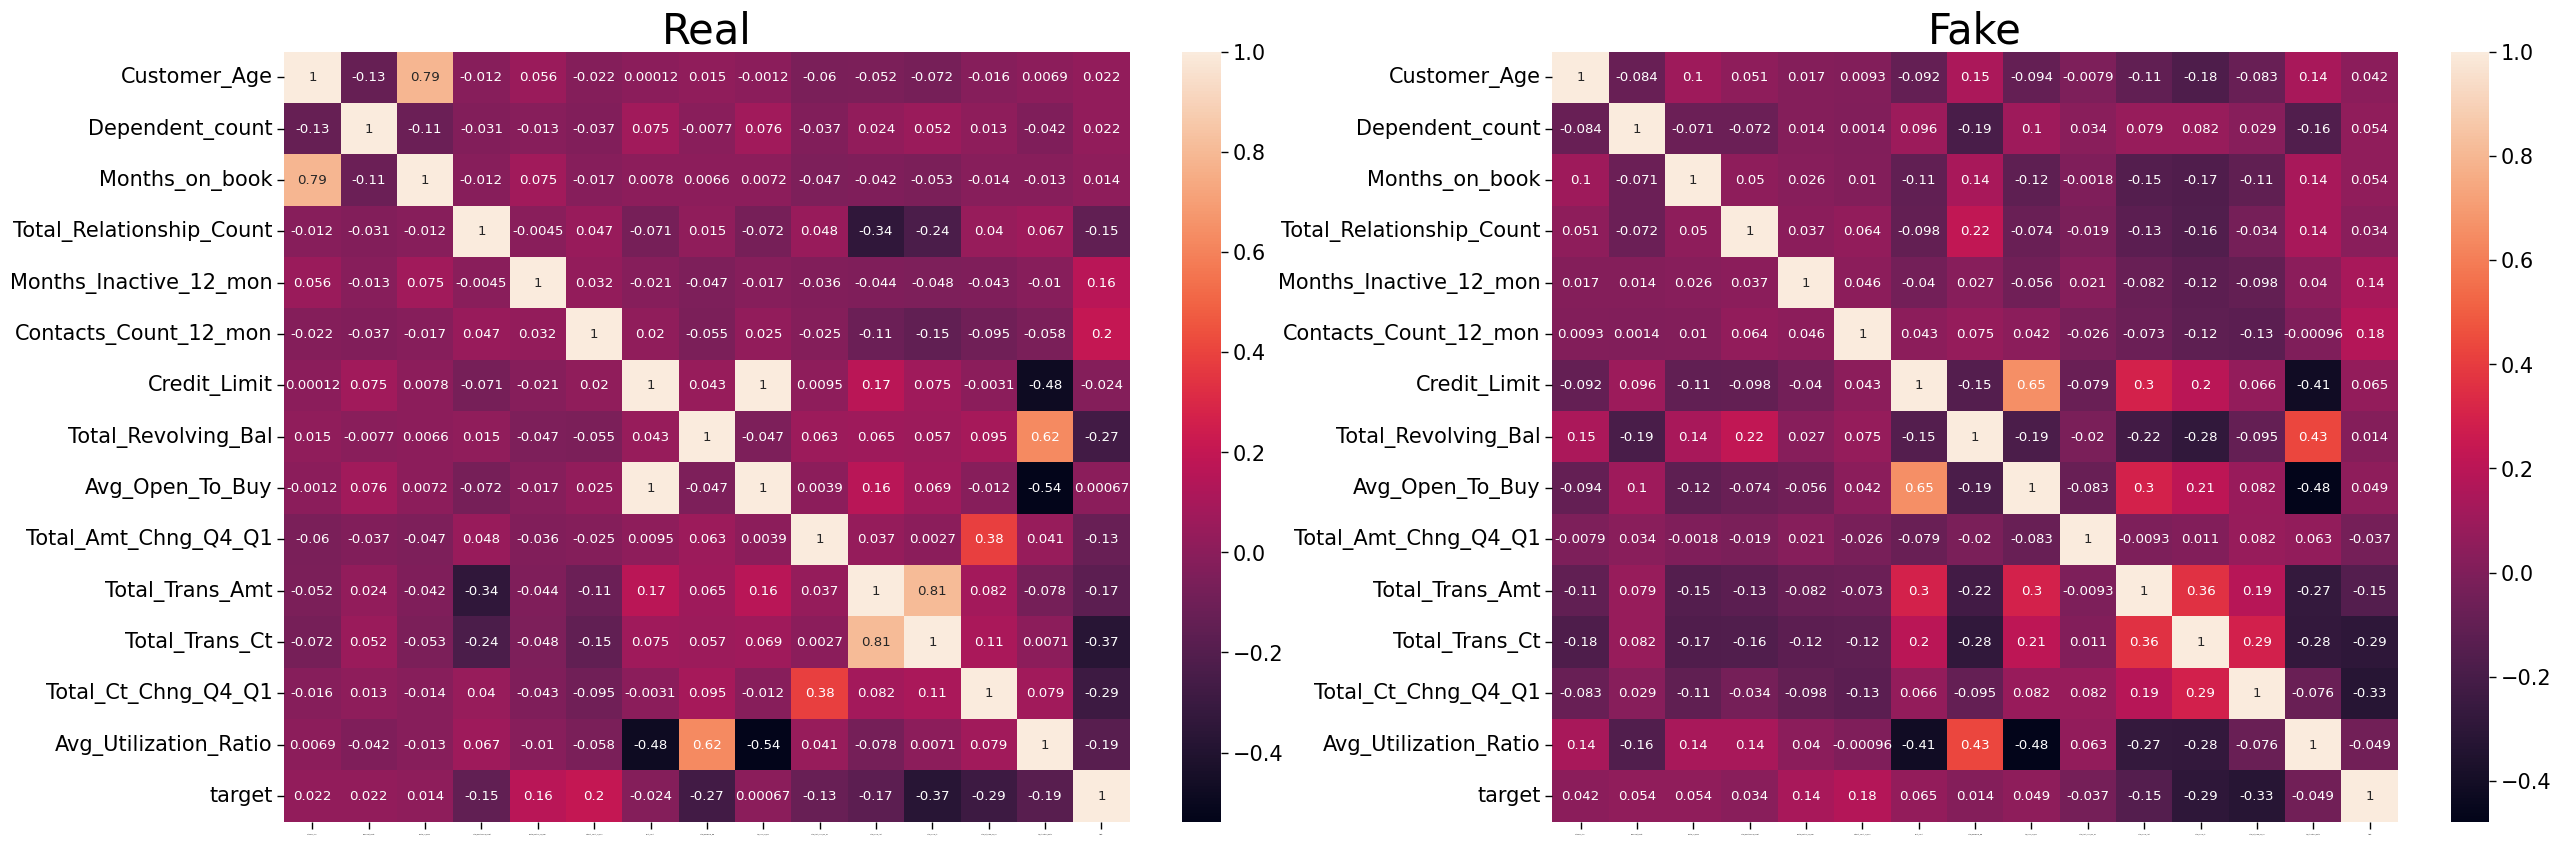

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(real_data.select_dtypes(exclude=['object']).corr(), ax=axes[0], annot=True)
sns.heatmap(synthetic_data.select_dtypes(exclude=['object']).corr(), ax=axes[1], annot=True)
axes[0].set_title('Real')
axes[1].set_title('Fake')
fig.show()

# Regression. Individual medical costs

In [35]:
data = pd.read_csv('drive/MyDrive/Diploma/data/Insurance.csv')
data.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [37]:
data.shape

(1338, 7)

In [38]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [40]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['charges'], axis=1),
                                                    data['charges'], test_size=0.1,
                                                    shuffle=True,
                                                    random_state=42)

In [42]:
real_data = X_train.copy()
real_data['charges'] = y_train
categorical_features = list(real_data.loc[:, real_data.dtypes == object].columns)

print(categorical_features)

['sex', 'smoker', 'region']


In [43]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(real_data)
python_dict = metadata.to_dict()

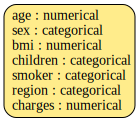

In [44]:
metadata.visualize()

In [92]:
%%time
ctgan_model_reg = CTGANSynthesizer(
    metadata, # required
    enforce_rounding=True,
    epochs=500,
    verbose=True,
    enforce_min_max_values=True
)
ctgan_model_reg.fit(real_data)

synthetic_data = ctgan_model_reg.sample(num_rows=real_data.shape[0])
synthetic_data.head()

Gen. (-1.16) | Discrim. (-0.02): 100%|██████████| 500/500 [01:24<00:00,  5.91it/s]


CPU times: user 1min 23s, sys: 1.83 s, total: 1min 25s
Wall time: 1min 35s


age     sex     bmi  children smoker     region       charges
0   52  female  19.168         0    yes  northwest  49355.282531
1   64    male  19.603         0     no  northeast  13146.136475
2   22  female  27.646         2     no  southwest   8124.407936
3   29  female  39.851         0     no  southwest   7556.017031
4   27    male  32.413         1    yes  northwest  13557.141266

In [93]:
from sdv.evaluation.single_table import run_diagnostic

diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 7/7 [00:00<00:00, 492.78it/s]|
Data Validity Score: 100.0%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 227.11it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 100.0%



In [94]:
from sdv.evaluation.single_table import evaluate_quality

quality_report = evaluate_quality(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 7/7 [00:00<00:00, 307.58it/s]|
Column Shapes Score: 89.74%

(2/2) Evaluating Column Pair Trends: |██████████| 21/21 [00:00<00:00, 30.92it/s]|
Column Pair Trends Score: 37.71%

Overall Score (Average): 63.72%



In [95]:
quality_report.get_details('Column Shapes')

Column        Metric     Score
0       age  KSComplement  0.858804
1       sex  TVComplement  0.884551
2       bmi  KSComplement  0.846346
3  children  TVComplement  0.973422
4    smoker  TVComplement  0.902824
5    region  TVComplement  0.957641
6   charges  KSComplement  0.857973

In [96]:
from sdv.evaluation.single_table import get_column_plot

feat_for_comp = real_data.columns.to_list()

for column_name in feat_for_comp:
  fig = get_column_plot(
  metadata=metadata,
  real_data=real_data,
  synthetic_data=synthetic_data,
  column_name=column_name,
  #plot_type='bar'
  )
  fig.show()

# Modeling

In [97]:
LinR_pipe = Pipeline([
    ('encoding', ce.OrdinalEncoder(
       encoding_method='ordered', variables=categorical_features)),
    ('scaler', StandardScaler()),
    ('LinReg', LinearRegression())
    ])

RFL_pipe = Pipeline([
    ('encoding', ce.OrdinalEncoder(
       encoding_method='ordered', variables=categorical_features)),
    ('scaler', StandardScaler()),
    ('RF', RandomForestRegressor())
    ])

In [98]:
y_pred_test_initial_linr = fit_predict(LinR_pipe, X_train.copy(), y_train, X_test, y_test, reg=True)
y_pred_test_ctgan_linr = fit_predict(LinR_pipe, synthetic_data.drop(['charges'], axis=1), synthetic_data['charges'], X_test, y_test, reg=True)

y_pred_test_initial_rfreg = fit_predict(RFL_pipe, X_train.copy(), y_train, X_test, y_test, reg=True)
y_pred_test_ctgan_rfreg = fit_predict(RFL_pipe, synthetic_data.drop(['charges'], axis=1), synthetic_data['charges'], X_test, y_test, reg=True)

y_pred_test_initial_lgbmreg = lgbm_predict(X_train.copy(), y_train, X_test, y_test, categorical_features, reg=True)
y_pred_test_ctgan_lgbmreg = lgbm_predict(synthetic_data.drop(['charges'], axis=1), synthetic_data['charges'], X_test, y_test, categorical_features, reg=True)

[LightGBM] [Warning] categorical_feature is set=sex,smoker,region, categorical_column=1,4,5 will be ignored. Current value: categorical_feature=sex,smoker,region
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1204, number of used features: 6
[LightGBM] [Info] Start training from score 13321.096783
[LightGBM] [Warning] categorical_feature is set=sex,smoker,region, categorical_column=1,4,5 will be ignored. Current value: categorical_feature=sex,smoker,region
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 1204, number of 

In [99]:
df_linr = pd.DataFrame(data=[mean_absolute_error(y_test,  y_pred_test_initial_linr), mean_absolute_error(y_test,  y_pred_test_ctgan_linr)],
                     columns = ['Test'],
                     index = ['Initial', 'CTGAN'] )
df_linr['model']='LinR'

df_rfreg = pd.DataFrame(data=[mean_absolute_error(y_test,  y_pred_test_initial_rfreg), mean_absolute_error(y_test,  y_pred_test_ctgan_rfreg)],
                     columns = ['Test'],
                     index = ['Initial', 'CTGAN'] )
df_rfreg['model']='RF'

df_lgbmreg = pd.DataFrame(data=[mean_absolute_error(y_test,  y_pred_test_initial_lgbmreg), mean_absolute_error(y_test,  y_pred_test_ctgan_lgbmreg)],
                   columns = ['Test'],
                      index = ['Initial', 'CTGAN'] )
df_lgbmreg['model']='Lgbm'

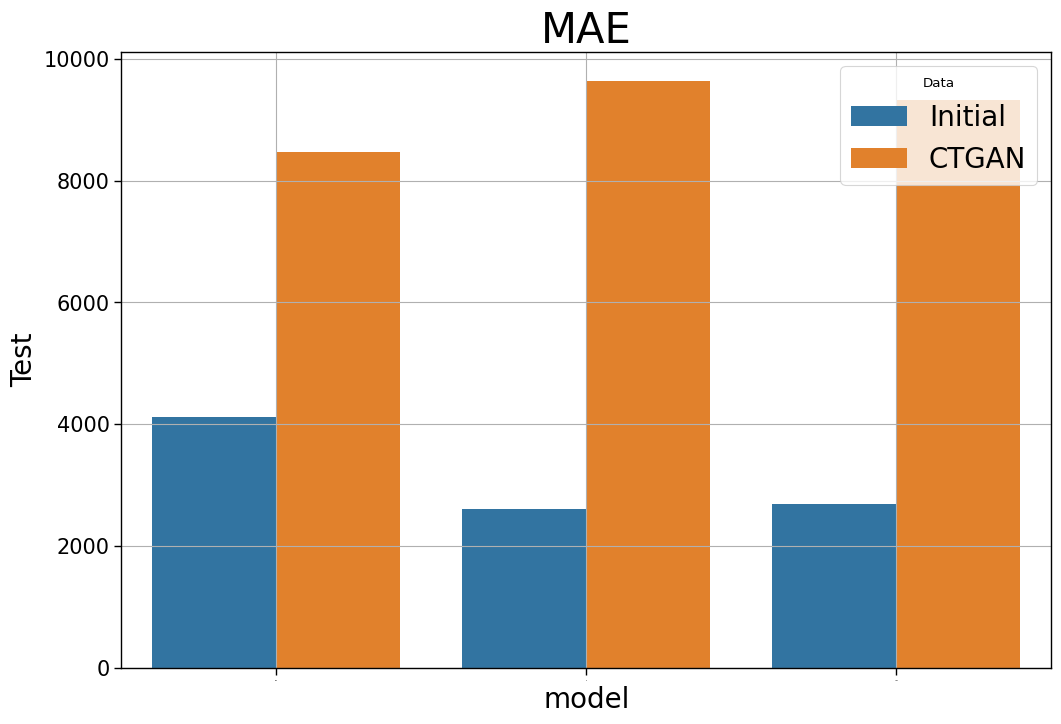

In [100]:
df=pd.concat([df_linr, df_rfreg, df_lgbmreg])
df.index.rename('Data', inplace=True)
df.reset_index(inplace=True)

fig = plt.figure(figsize=(12,8))
sns.barplot(x = 'model', y = 'Test', hue = 'Data', data = df)
plt.title('MAE')
plt.grid()
plt.show()

In [80]:
df

Data          Test model
0  Initial   4121.977409  LinR
1    CTGAN   9861.834267  LinR
2  Initial   2579.619065    RF
3    CTGAN  11199.808289    RF
4  Initial   2687.801355  Lgbm
5    CTGAN  11290.373807  Lgbm

In [86]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

categorical_features_indices = [i for i, col in enumerate(data.columns) if data[col].dtype == 'object']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), categorical_features_indices)
    ],
    remainder='passthrough'
)

# Создание конвейера (pipeline) с преобразованием и моделью
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Обучение модели
pipeline.fit(synthetic_data.drop(['charges'], axis=1), synthetic_data['charges'])

# Предсказание на тестовых данных
y_pred = pipeline.predict(X_test)

# Оценка качества модели
mean_absolute_error(y_test, y_pred)

9807.321414928676

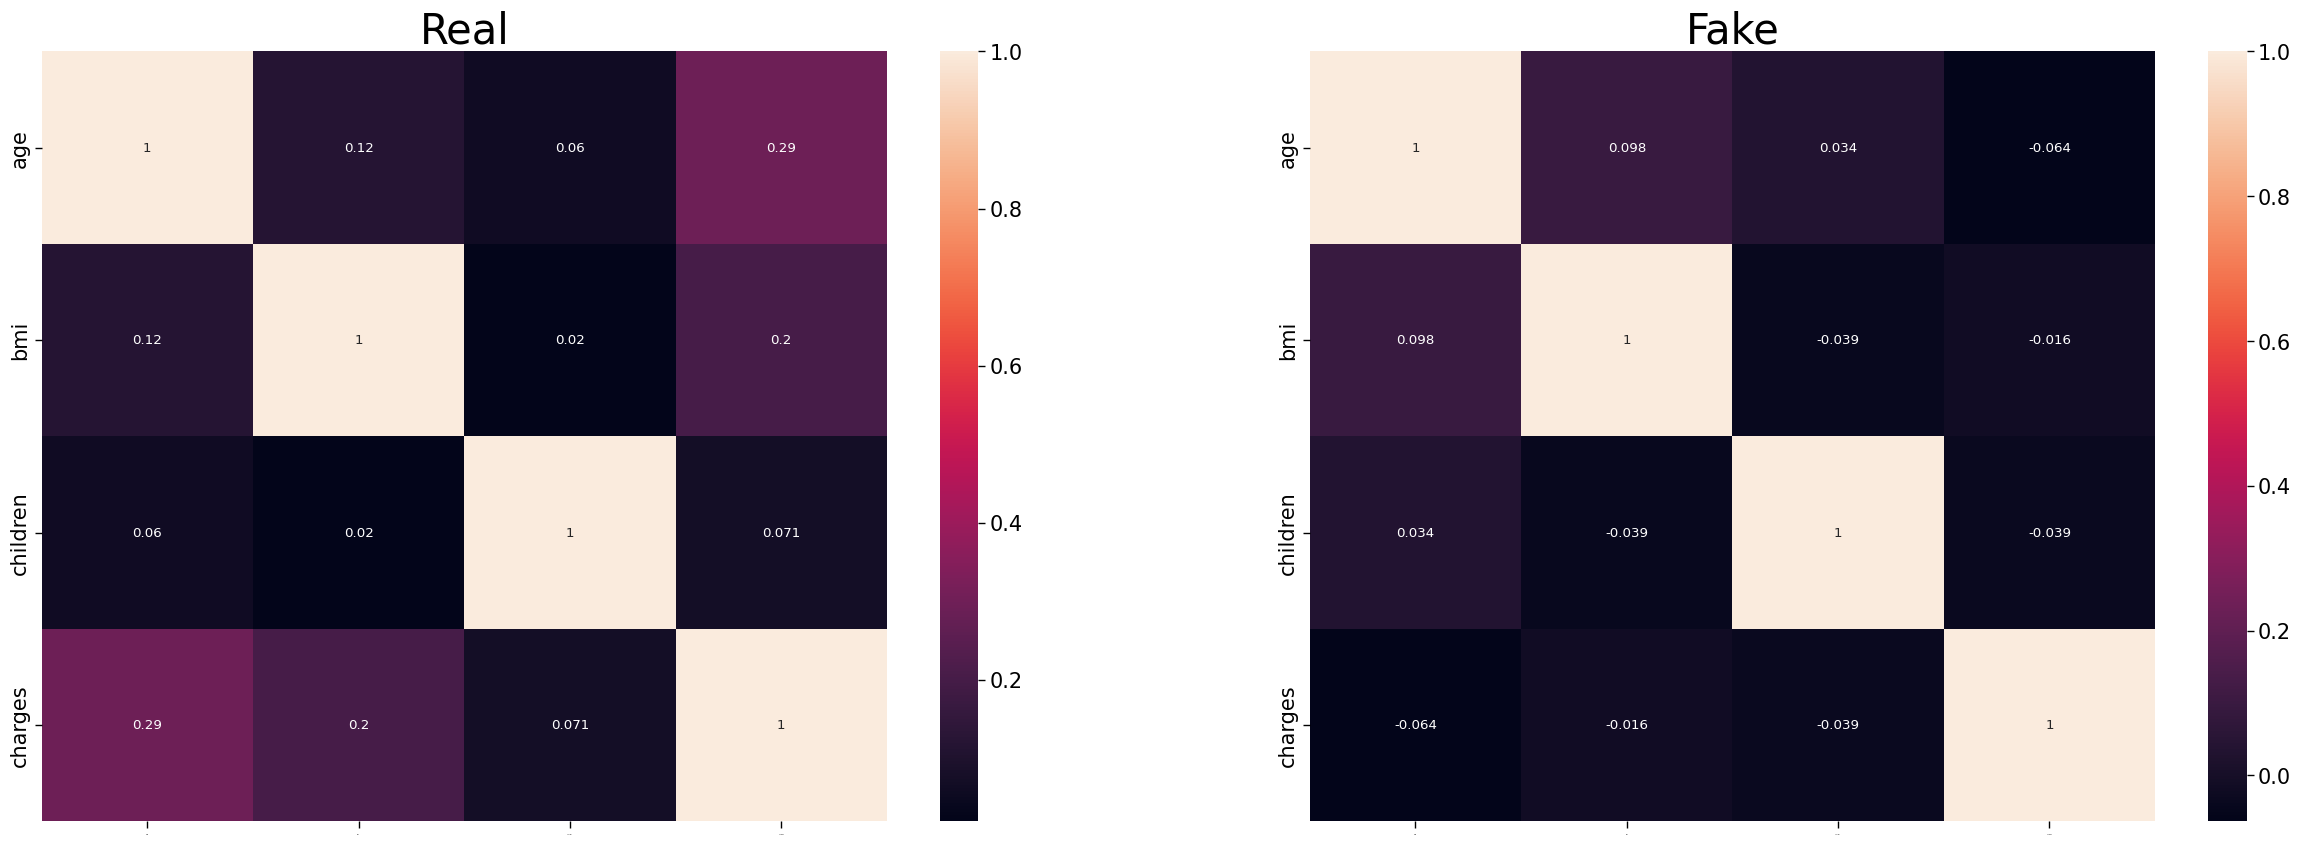

In [91]:
fig, axes = plt.subplots(1, 2, figsize=(30, 10))
sns.heatmap(real_data.select_dtypes(exclude=['object']).corr(), ax=axes[0], annot=True)
sns.heatmap(synthetic_data.select_dtypes(exclude=['object']).corr(), ax=axes[1], annot=True)
axes[0].set_title('Real')
axes[1].set_title('Fake')
fig.show()

### Anonymization

In [ ]:
synthetic_data.address.isin(data_pii.address).sum()

0

In [ ]:
sensitive_column_names = ['address']

data_pii[sensitive_column_names].head(3)

address
0      70304 Baker Turnpike\nEricborough, MS 15086
1  805 Herrera Avenue Apt. 134\nMaryview, NJ 36510
2      3702 Bradley Island\nNorth Victor, FL 12268

In [ ]:
synthetic_data[sensitive_column_names].head(3)

address
0                       USNS Galvan\nFPO AP 90222
1  01622 James Ranch\nSouth Charlesberg, WV 02992
2    385 Kathleen Mission\nRichardsfurt, MD 81989

### Conditional generation

In [ ]:
from sdv.sampling import Condition

condition = Condition(
    column_values={
    'gender': 'M',
    'experience_years': 0
    },
    num_rows=5)

synthetic_data = ctgan_model.sample_from_conditions(conditions=[condition])

Sampling conditions: 100%|██████████| 5/5 [00:00<00:00,  7.42it/s]
